In [2]:
"""
Implementation of a simple multivalent binding model.
"""

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from scipy.optimize import minimize, curve_fit
from src.MBmodel import cytBindingModel, resids, residsSeq, fitFunc, getConfInterval, getConfIntervalSeq, R2_Plot_Cells, R2_Plot_Ligs, affFit, affFitSeq

/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)
0.7550448422959622


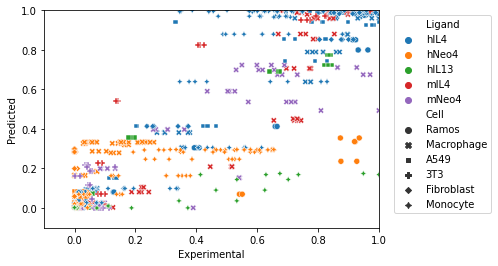

In [2]:
xOpt = pd.read_csv("src/data/CurrentFit.csv").x.values
modelDF = resids(xOpt, True)
sns.scatterplot(data=modelDF, x="Experimental", y="Predicted", hue="Ligand", style="Cell")
plt.xlim(-.1, 1)
plt.ylim(-.1, 1)
plt.legend(loc='upper right', bbox_to_anchor=(1.35, 1.0))
#plt.savefig("UnConstrainedFit.svg")
print(r2_score(modelDF.Experimental.values, modelDF.Predicted.values))


/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)
0.8055810425089336


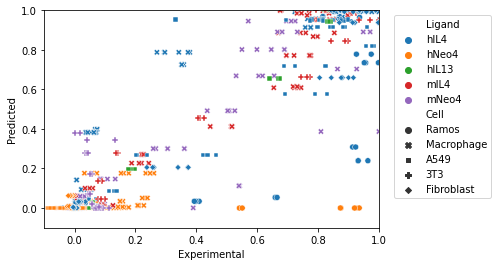

In [3]:
xOpt = pd.read_csv("src/data/CurrentFitSeq.csv").x.values
modelDF = residsSeq(xOpt, True)
sns.scatterplot(data=modelDF, x="Experimental", y="Predicted", hue="Ligand", style="Cell")
plt.xlim(-.1, 1)
plt.ylim(-.1, 1)
plt.legend(loc='upper right', bbox_to_anchor=(1.35, 1.0))
print(r2_score(modelDF.Experimental.values, modelDF.Predicted.values))

In [4]:
np.power(np.power(10, xOpt[2::]), -1) * np.power(10, 9)

array([8.36922251e+10, 1.00000000e+12, 3.83557898e+08, 8.30237585e+17,
       1.00000000e+05, 9.93906927e+06, 1.20695348e+12, 1.00000000e+05,
       1.54578842e+12, 4.79404088e+11, 1.99526231e+06])

In [5]:
from scipy.optimize import root, least_squares

def IL4Func(x, KDs, recs, conc):
    print(x, (x*conc)/KDs[0], recs[1]/((KDs[0]*KDs[1])/(x*conc)+1), recs[2]/((KDs[0]*KDs[2])/(x*conc)+1))
    return recs[0] - (x + (x*conc)/KDs[0] + recs[1]/(KDs[0]*KDs[1]/(x*conc)+1) + recs[2]/((KDs[0]*KDs[2])/(x*conc)+1))

KDs = [1e-7, 10, 5]
recs = [400, 5000, 10000]
conc = 1e-11
x0 = 1000
bnds = ((0, recs[0]))

IL4Ra = least_squares(IL4Func, x0=recs[0], args=(KDs, recs, conc)).x

def SignalingFunc(IL4Ra, KDs, recs, conc, T2W):
    return recs[1]/(KDs[0]*KDs[1]/(IL4Ra*conc)+1) + recs[2]/((KDs[0]*KDs[2])/(IL4Ra*conc)+1) * T2W

print(SignalingFunc(IL4Ra, KDs, recs, conc, 1))
    

[400.] [0.04] [19.92031873] [79.36507937]
[400.00000596] [0.04] [19.92031902] [79.36508054]
[320.31914882] [0.03203191] [15.96481907] [63.65602489]
[320.31915359] [0.03203192] [15.96481931] [63.65602583]
[320.34157854] [0.03203416] [15.9659334] [63.6604539]
[320.34158331] [0.03203416] [15.96593364] [63.66045484]
[79.6263873]


/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)
0.8055810425089336
/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


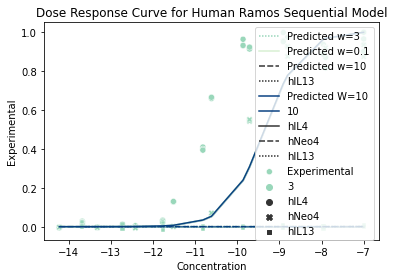

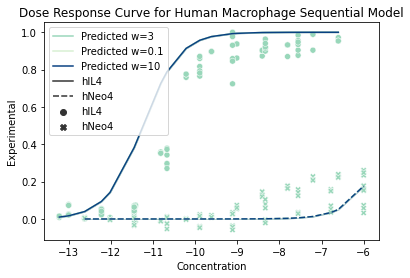

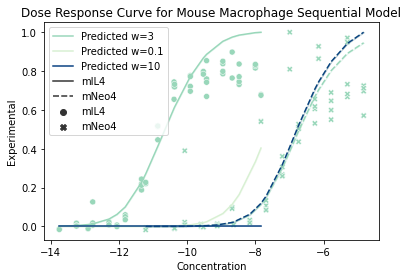

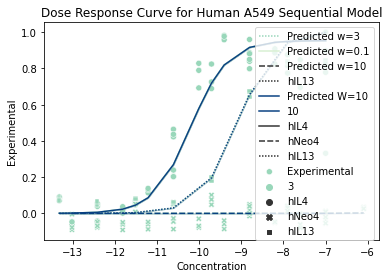

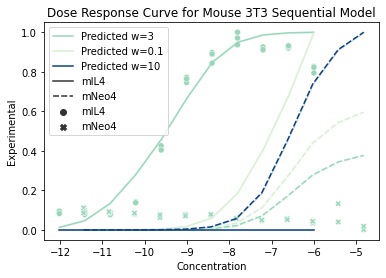

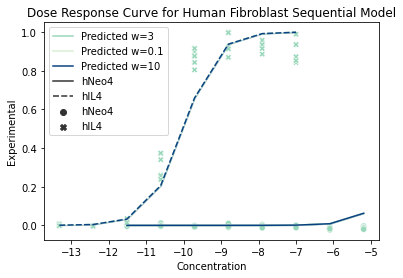

In [6]:
xOptimal = pd.read_csv("src/data/CurrentFitSeq.csv").x.values


#Generate range of xOptimals
xOpts = [xOptimal]

weights = [0.1,10]

for weight in weights:
    xOptimal_new = np.copy(xOptimal)
    xOptimal_new[0] = weight
    xOpts.append(xOptimal_new)

#print("xOpts Length "+ str(len(xOpts)))
#Generate range of models
modelDF = residsSeq(xOptimal, True)
print(r2_score(modelDF.Experimental.values, modelDF.Predicted.values))

modelDFs = [modelDF]

for i in range(1,len(xOpts)):
    modelDF_new = residsSeq(xOpts[i], True)
    modelDFs.append(modelDF_new)

#print("modelDFs Length "+ str(len(modelDFs)))


for cell in modelDF.Cell.unique():
    for animal in modelDF.loc[modelDF.Cell == cell].Animal.unique():
        weights = [3,0.1,10]
        isoData = modelDF.loc[(modelDF.Cell == cell) & (modelDF.Animal == animal)]
        #sns.set_palette("Paired")
        fig, ax = plt.subplots()
        sns.scatterplot(data=isoData, x="Concentration", y="Experimental", label="Experimental", style="Ligand",palette="GnBu", hue=3,hue_norm=(-2,10))
        for i, modelDF_ in enumerate(modelDFs):
            isoData_ = modelDF_.loc[(modelDF_.Cell == cell) & (modelDF_.Animal == animal)]
            sns.lineplot(data=isoData_, x="Concentration", y="Predicted", label="Predicted W="+str(weights[i]), style="Ligand", palette="GnBu", hue=weights[i], hue_norm=(-2,10))
        ax.set_title("Dose Response Curve for " + animal + " " + cell + " Sequential Model")
        handles, labels = ax.get_legend_handles_labels()
        #print(handles)
        #print(labels)
        ax.legend([handles[2]] + [handles[7]] + [handles[12]]+ handles[13:15] + handles[17::], ["Predicted w=3"] + ["Predicted w=0.1"] + ["Predicted w=10"] + labels[13:15] + labels[17::])
        #plt.savefig("UnConstrained"+animal+cell+".svg")

/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)
0.8720776265476569


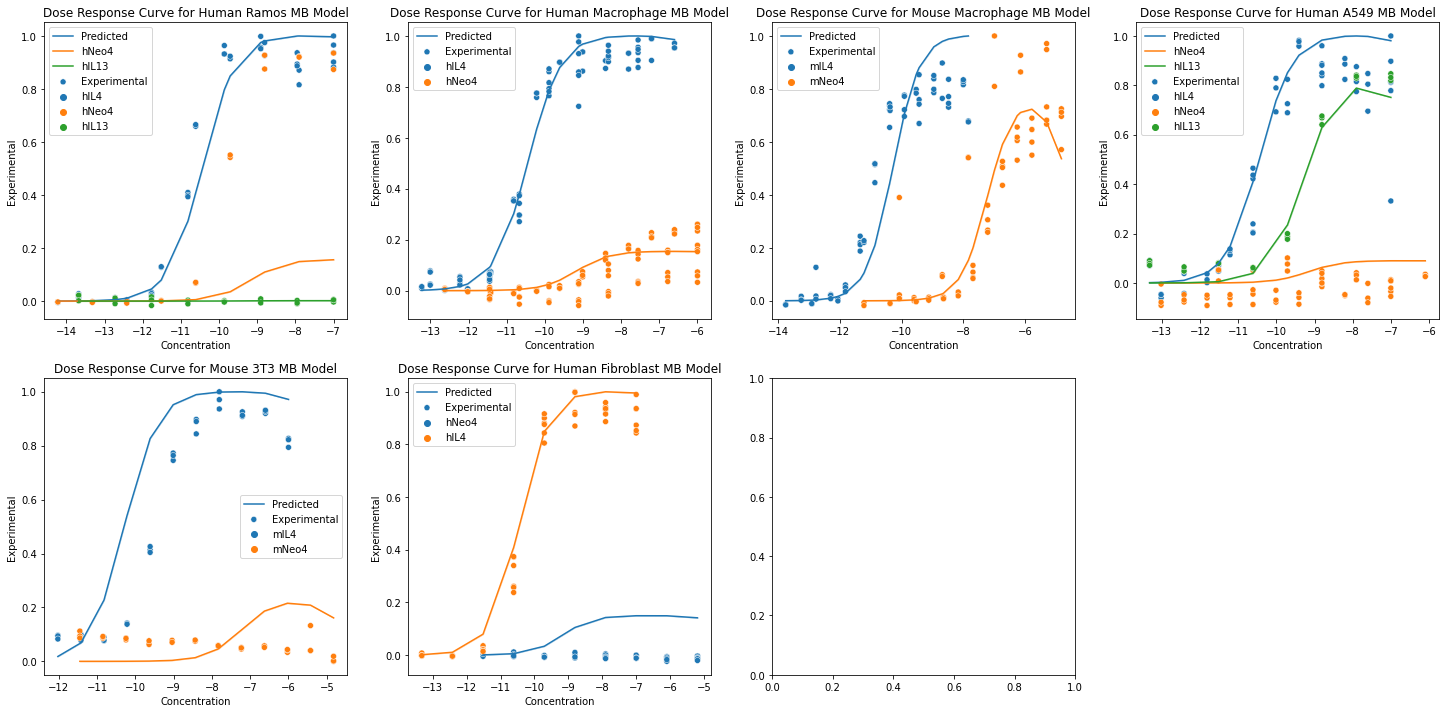

In [7]:
xOptimal = pd.read_csv("src/data/CurrentFit.csv").x.values
modelDF = resids(xOptimal, True)
print(r2_score(modelDF.Experimental.values, modelDF.Predicted.values))
fig, ax = plt.subplots(2, 4, figsize=(25, 12))
ax = np.ravel(ax)
ax[-1].axis("off")
i = 0

for cell in modelDF.Cell.unique():
    for animal in modelDF.loc[modelDF.Cell == cell].Animal.unique():
        isoData = modelDF.loc[(modelDF.Cell == cell) & (modelDF.Animal == animal)]
        sns.scatterplot(data=isoData, x="Concentration", y="Experimental", label="Experimental", hue="Ligand", ax=ax[i])
        sns.lineplot(data=isoData, x="Concentration", y="Predicted", label="Predicted", hue="Ligand", ax=ax[i])
        ax[i].set(title="Dose Response Curve for " + animal + " " + cell + " MB Model")
        handles, labels = ax[i].get_legend_handles_labels()
        ax[i].legend([handles[0]] + handles[4::], [labels[0]] + labels[4::])
        i += 1

plt.savefig("MBDoseResponse.svg")

/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)
0.6563845467037189


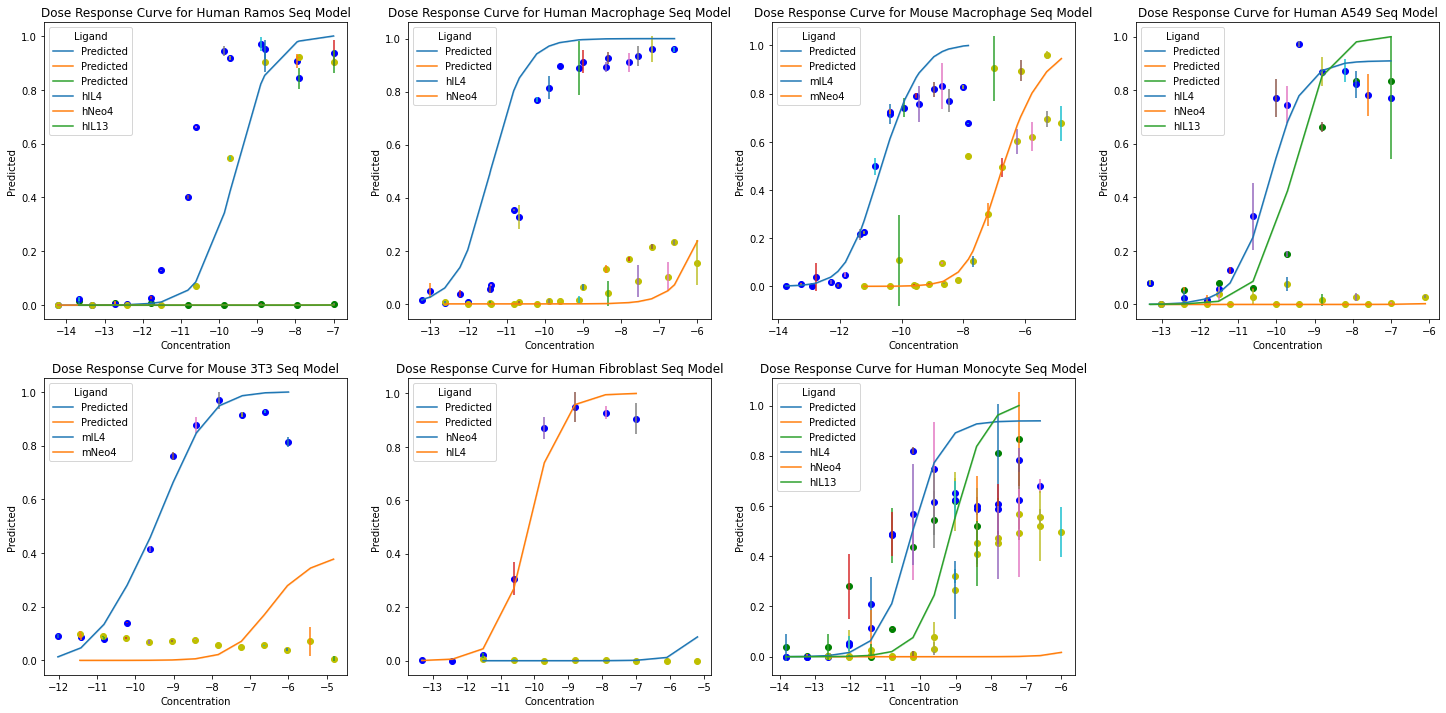

In [30]:
xOptimal = pd.read_csv("src/data/CurrentFitSeq.csv").x.values
modelDF = residsSeq(xOptimal, True)
print(r2_score(modelDF.Experimental.values, modelDF.Predicted.values))
fig, ax = plt.subplots(2, 4, figsize=(25, 12))
ax = np.ravel(ax)
ax[-1].axis("off")
i = 0
meanDF = modelDF.groupby(["Animal", "Cell", "Ligand", "Concentration"])['Experimental'].mean().reset_index()
stdDF = modelDF.groupby(["Animal", "Cell", "Ligand", "Concentration"])['Experimental'].std().reset_index()
colorDict = {"hIL4": "blue", "hNeo4": "yellow", "mIL4": "blue", "mNeo4": "yellow", "hIL13": "green"}


for cell in modelDF.Cell.unique():
    for animal in modelDF.loc[modelDF.Cell == cell].Animal.unique():
        isoData = modelDF.loc[(modelDF.Cell == cell) & (modelDF.Animal == animal)]
        means = meanDF.loc[(meanDF.Cell == cell) & (meanDF.Animal == animal)]
        stds = stdDF.loc[(stdDF.Cell == cell) & (stdDF.Animal == animal)]
        #sns.scatterplot(data=isoData, x="Concentration", y="Experimental", label="Experimental", hue="Ligand", ax=ax[i])
        for j, ligand in enumerate(means.Ligand.values):
            ax[i].scatter(x=means.Concentration.values[j], y=means.Experimental.values[j], color=colorDict[ligand])
            ax[i].errorbar(x=means.Concentration.values[j], y=means.Experimental.values[j], yerr=stds.Experimental.values[j], ls='none', color=colorDict[ligand]))
        sns.lineplot(data=isoData, x="Concentration", y="Predicted", label="Predicted", hue="Ligand", ax=ax[i])
        ax[i].set(title="Dose Response Curve for " + animal + " " + cell + " Seq Model")
        handles, labels = ax[i].get_legend_handles_labels()
        if len(isoData.Ligand.unique()) == 2:
            ax[i].legend([handles[0]] + handles[4::], [labels[0]] + labels[4::])
        else:
            ax[i].legend([handles[0]] + handles[4::], [labels[0]] + labels[4::])
        i += 1

plt.savefig("SeqDoseResponse.svg")

In [26]:
modelDF.groupby(["Animal", "Cell", "Ligand", "Concentration"])['Experimental'].mean().reset_index()
#modelDF.groupby(["Cell", "Ligand", "Concentration"])['Experimental'].std().reset_index()

,Animal,Cell,Ligand,Concentration,Experimental
0,Human,A549,hIL13,-13.321600,0.080145
1,Human,A549,hIL13,-12.418500,0.053461
2,Human,A549,hIL13,-11.515400,0.080078
3,Human,A549,hIL13,-10.612400,0.060667
4,Human,A549,hIL13,-9.709270,0.188126
...,...,...,...,...,...
244,Mouse,Macrophage,mNeo4,-6.146128,0.895582
245,Mouse,Macrophage,mNeo4,-5.778150,0.621393
246,Mouse,Macrophage,mNeo4,-5.301030,0.693727
247,Mouse,Macrophage,mNeo4,-5.301030,0.959916


/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


Text(0.5, 1.0, 'Sequential binding model')

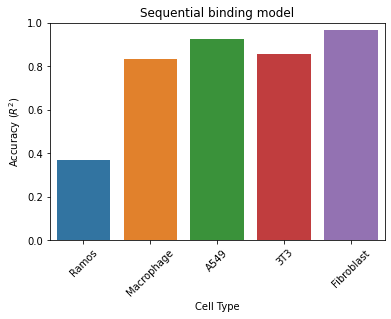

In [9]:
xOptimal = pd.read_csv("src/data/CurrentFitSeq.csv").x.values
modelDF = residsSeq(xOptimal, True)
R2_Plot_Cells(modelDF)
plt.title("Sequential binding model")

/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


Text(0.5, 1.0, 'Multivalent binding model')

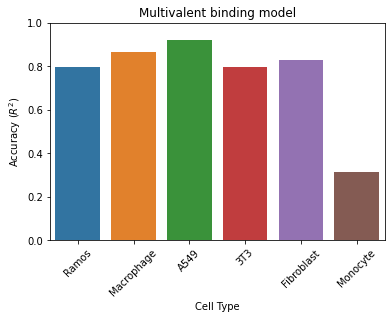

In [3]:
xOptimal = pd.read_csv("src/data/CurrentFit.csv").x.values
modelDF = resids(xOptimal, True)
R2_Plot_Cells(modelDF)
plt.title("Multivalent binding model")

/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


Text(0.5, 1.0, 'Sequential binding model')

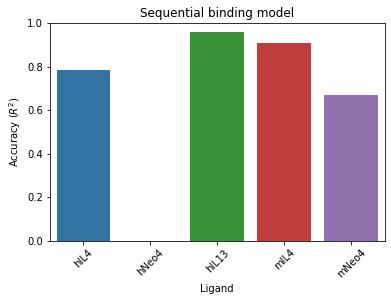

In [11]:
xOptimal = pd.read_csv("src/data/CurrentFitSeq.csv").x.values
modelDF = residsSeq(xOptimal, True)
R2_Plot_Ligs(modelDF)
plt.title("Sequential binding model")

/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


Text(0.5, 1.0, 'Multivalent binding model')

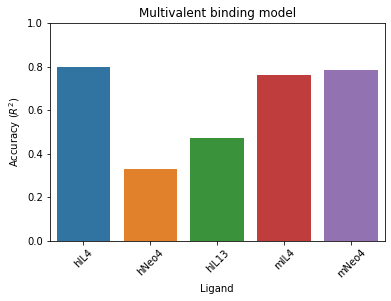

In [4]:
xOptimal = pd.read_csv("src/data/CurrentFit.csv").x.values
modelDF = resids(xOptimal, True)
R2_Plot_Ligs(modelDF)
plt.title("Multivalent binding model")

/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)
[-13.99980859  10.28347374   4.           4.5281471    7.21802212
   4.49150257  10.44965138   4.80512698   5.71265087   9.16711875
   4.           9.30457333   6.           0.08518445]
3.5238813533200615
[-13.99980849  10.28347374   4.           4.5281471    7.21802212
   4.49150257  10.44965138   4.80512698   5.71265087   9.16711875
   4.           9.30457333   6.           0.08518445]
3.5238813533188043
[-13.99980859  10.28347384   4.           4.5281471    7.21802212
   4.49150257  10.44965138   4.80512698   5.71265087   9.16711875
   4.           9.30457333   6.           0.08518445]
3.5238813533176483
[-13.9

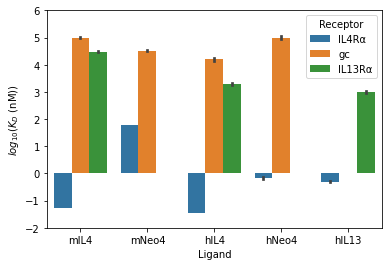

In [13]:
confInt = getConfInterval()
affFit(confInt)

/home/brianoj/IL4-model/src/MBmodel.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fitDictKDNorm[r"$K_D$"] += 9
  Ligand Receptor     $K_D$
0   mIL4       gc -3.492717
0   mIL4   IL13Rα -1.922605
0  mNeo4       gc  0.416139
0   hIL4       gc  4.000000
0   hIL4   IL13Rα  2.297673
0  hNeo4       gc  4.000000
0  hIL13   IL13Rα -3.356883


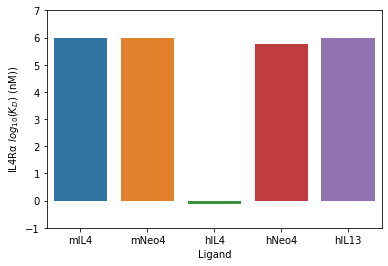

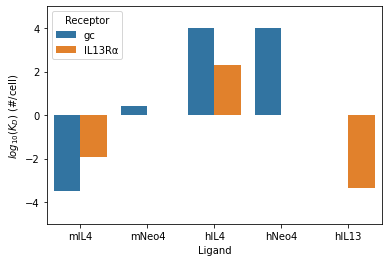

In [2]:
#confIntSeq = getConfIntervalSeq()
affFitSeq(np.array([False]))